<a href="https://colab.research.google.com/github/VMBoehm/SDSS_PAE/blob/main/LSTM_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Template and tests for an LSTM Auto-Encoder


In [1]:
import tensorflow as tf

In [2]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
tf.__version__

'2.2.0'

In [4]:
import tensorflow_datasets as tfds

In [5]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import os

In [6]:
# ! pip install tensorflow-probability==0.11.0
! pip install --user -e /global/homes/v/vboehm/codes/SDSS_PAE/    

Obtaining file:///global/homes/v/vboehm/codes/SDSS_PAE
  Attempting uninstall: sdss-pae
    Found existing installation: sdss-pae 0.1.0
    Uninstalling sdss-pae-0.1.0:
      Successfully uninstalled sdss-pae-0.1.0
  Running setup.py develop for sdss-pae


In [7]:
import tensorflow_probability as tfp

In [8]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import LSTM, Layer, Reshape, LeakyReLU, BatchNormalization
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, UpSampling1D, AveragePooling1D
from tensorflow.keras.layers import RepeatVector, Conv2DTranspose, Flatten
from tensorflow.keras.layers import TimeDistributed, Input, Lambda, Masking, Dropout
import tensorflow.keras.backend as K

In [9]:
def Conv1DTranspose(input_tensor, filters, kernel_size, strides=2, padding='valid', output_padding=0, name=None):
    """
        input_tensor: tensor, with the shape (batch_size, time_steps, dims)
        filters: int, output dimension, i.e. the output tensor will have the shape of (batch_size, time_steps, filters)
        kernel_size: int, size of the convolution kernel
        strides: int, convolution step size
        padding: 'same' | 'valid'
    """
    x = Lambda(lambda x: K.expand_dims(x, axis=2))(input_tensor)
    x = Conv2DTranspose(filters=filters, kernel_size=(kernel_size, 1), strides=(strides, 1), padding=padding, output_padding=(output_padding,0), name=name)(x)
    x = Lambda(lambda x: K.squeeze(x, axis=2))(x)
    return x

In [67]:
### settings
# user defined span (following Yip et al and Portillo et al)
root_models     = '/global/cscratch1/sd/vboehm/Models/SDSS_AE/'

root_encoded    = '/global/cscratch1/sd/vboehm/Datasets/encoded/sdss/'
root_decoded    = '/global/cscratch1/sd/vboehm/Datasets/decoded/sdss/'
root_data       = '/global/cscratch1/sd/vboehm/Datasets'

root_prepped    = os.path.join(root_data,'sdss/prepped')

wlmin, wlmax    = (3388,8318)
fixed_num_bins  = 1000
latent_dim      = 10
network_type    = 'fully_connected'
label           = 'galaxies_quasars_bins1000_wl3388-8318'
label_          = label+'_minz005_maxz036_minSN50'
label_2         = label_+'_10_fully_connected'

seed            = 8720

In [31]:
wl_range      = (np.log10(wlmin),np.log10(wlmax))
# new binning 
new_wl        = np.logspace(wl_range[0],wl_range[1],fixed_num_bins+1)

In [32]:
res_fluxes, res_masks, res_inv_vars = np.load(os.path.join(root_prepped,'prepped_data_spectra_%s.npy'%label_),allow_pickle=True)

redshifts, SNs, ras, decs, category, sublabel = np.load(os.path.join(root_prepped,'prepped_data_prop_%s.npy'%label_),allow_pickle=True)

In [33]:
dim = fixed_num_bins

In [143]:
class bottleneck(Layer):
    def __init__(self, units, dim, **kwargs):
        self.units  = units
        self.dim    = dim
        self.LSTM1  = LSTM(units[0],  return_sequences=True)
        self.LSTM2  = LSTM(units[1],  return_sequences=False)
        self.Repeat = RepeatVector(dim)
        super(bottleneck, self).__init__(**kwargs)

    def call(self, inputs):
        return self.Repeat(self.LSTM2(self.LSTM1(inputs)))

    def compute_mask(self, inputs, mask=None):
        return mask


input        = Input(shape=(dim,1))
input_params = Input(shape=(1))
input_mask   = Input(shape=(dim,1))
input_noise  = Input(shape=(dim,1))


if network_type=='fully_connected':
# simplest, not many architectural choices other than number of neurons, likely to overfit
    #encoder_input = input#tf.concat([input,tf.tile(input_z,[tf.shape(input)[0],1])], axis=1)
#    x = Reshape((dim,))(input)
#    x = tf.concat([input,input_params],axis=1)
    x = Flatten()(input)
    x = Dense(256)(x)
    x = BatchNormalization()(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(16)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(latent_dim)(x)  
    #x = tf.concat([x,input_params],axis=1)
    #z = Flatten()(input_params)
    #x = tf.concat([input_params,x], axis=1)
    x = Dense(16)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(64)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(128)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = Dense(512)(x)
    x = BatchNormalization()(x)
    x = Dense(dim)(x)
    x = Reshape((dim,1))(x)
elif network_type=='LSTM':
# slow training
    x = LSTM(256, return_sequences=True)(input)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = LSTM(latent_dim,  return_sequences=False, name='bottleneck')(x)
    x = RepeatVector(dim)(x)
    x = LSTM(latent_dim, return_sequences=True)(x)
    x = BatchNormalization()(x)
    x = LeakyReLU()(x)
    x = LSTM(256, return_sequences=True)(x)
    x = TimeDistributed(Dense(1))(x)
elif network_type=='CNN':
# better than fully connected, but more choices to make for architecture, performance might be very much dependent on architecture
    x = Conv1D(filters=64,kernel_size=(5), strides=2, name='conv1', padding='same')(input)
    x = BatchNormalization(name='bn1')(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2, name='maxpool1', padding='same')(x)
    x = Conv1D(filters=32,kernel_size=(3), strides=2,name='conv2', padding='same')(x)
    x = BatchNormalization(name='bn2')(x)
    x = LeakyReLU()(x)
    x = MaxPooling1D(2,name='maxpool2', padding='same')(x)
    x = Conv1D(filters=32,kernel_size=(3), strides=2, name='conv3', padding='same')(x)
    x = BatchNormalization(name='bn3')(x)
    x = LeakyReLU()(x)
    x = Flatten()(x)
    #x = tf.concat([y,input_params],axis=1)
    x = Dense(latent_dim, name='fc_enc')(x)
    x = LeakyReLU()(x)
    #x = tf.concat([z,input_params], axis=1)
    x = Dense(1024,name='fc_dec')(x)
    x = LeakyReLU()(x)
    x = Reshape((32,32))(x)
    x = Conv1DTranspose(input_tensor=x,filters=32,kernel_size=(3),strides=2, name='conv1T', padding='same')
    x = BatchNormalization(name='bn1T')(x)
    x = LeakyReLU()(x)
    #x = UpSampling1D(2, name='up1')(x)
    x = Conv1DTranspose(input_tensor=x,filters=32,kernel_size=(3),strides=2, name='conv2T', padding='same')
    x = BatchNormalization(name='bn2T')(x)
    x = LeakyReLU()(x)
    x = UpSampling1D(2,name='up2')(x)
    x = Conv1DTranspose(input_tensor=x,filters=64,kernel_size=(5),strides=2, name='conv3T', padding='same')
    x = BatchNormalization(name='bn3T')(x)
    x = LeakyReLU()(x)
    x = Conv1DTranspose(input_tensor=x,filters=1,kernel_size=(1),strides=1, padding='same')
#    x = Reshape((dim,1))(x)
else:
    raise ValueError('Network type not supported')

def lossFunction(y_true,y_pred,mask,inverse):
        loss = tf.math.square(y_true-y_pred)*inverse
        loss = tf.reduce_mean(tf.boolean_mask(loss,mask))
        return loss
    
from tensorflow.python.keras.engine import data_adapter


class CustomModel(tf.keras.Model):
    def compile(self, optimizer, my_loss,metrics, run_eagerly):
        super().compile(optimizer,metrics, run_eagerly)
        self.my_loss = my_loss

    def train_step(self, data):
        data = data_adapter.expand_1d(data)
        input_data = data_adapter.unpack_x_y_sample_weight(data)
        with tf.GradientTape() as tape:
            y_pred = self(input_data[0], training=True)
            loss_value = self.my_loss(input_data[0][0],y_pred,input_data[0][1],input_data[0][2])

        grads = tape.gradient(loss_value, self.trainable_variables)
        self.optimizer.apply_gradients(zip(grads, self.trainable_variables))

        return {"training_loss": loss_value}
    
    


In [144]:
tf.random.set_seed(seed)


lstm_ae = CustomModel(inputs=[input,input_mask,input_noise, input_params], outputs=x)
lstm_ae.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), my_loss=lossFunction, metrics=[],run_eagerly=False)

# lstm_ae = Model(inputs=[input, input1,input2, input_float], outputs=[x, input1,input2, input_float])
# lstm_ae.compile(optimizer='adam', loss=lossFunction)
print(lstm_ae.summary())

Model: "custom_model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 1000, 1)]    0                                            
__________________________________________________________________________________________________
flatten_4 (Flatten)             (None, 1000)         0           input_17[0][0]                   
__________________________________________________________________________________________________
dense_40 (Dense)                (None, 256)          256256      flatten_4[0][0]                  
__________________________________________________________________________________________________
batch_normalization_32 (BatchNo (None, 256)          1024        dense_40[0][0]                   
_____________________________________________________________________________________

In [145]:
def make_scheduler(length):
    
    def scheduler(epoch, lr):
        if epoch < length:
            lr=1e-3
            return lr
        else:
            return lr * tf.math.exp(-1.5)
        
    return scheduler



In [146]:
mean=np.mean(res_fluxes)
print(mean)

225519.15141530745


In [147]:
BATCH_SIZE   = 32

In [148]:

DATASET_SIZE = len(res_fluxes)
train_size   = int(0.6 * DATASET_SIZE)
test_size    = int(0.2 * DATASET_SIZE)
valid_size   = int(0.2 * DATASET_SIZE)
indices      = np.arange(DATASET_SIZE)

In [149]:
np.random.seed(seed)
np.random.shuffle(indices)

In [150]:
def reshuffle(list_, indices):
    res = []
    for item_ in list_:
        res.append(item_[indices])
    return res

In [151]:
res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, category, sublabel = reshuffle([res_fluxes, res_masks, res_inv_vars, redshifts, SNs, ras, decs, category, sublabel], indices)

In [152]:
train_data   = np.expand_dims(res_fluxes[:train_size],-1)/mean
valid_data   = np.expand_dims(res_fluxes[train_size:train_size+valid_size],-1)/mean
test_data    = np.expand_dims(res_fluxes[-test_size::],-1)/mean

train_mask   = np.expand_dims(res_masks[:train_size],-1)
valid_mask   = np.expand_dims(res_masks[train_size:train_size+valid_size],-1)
test_mask    = np.expand_dims(res_masks[-test_size::],-1)

train_noise  = np.expand_dims(res_inv_vars[:train_size],-1)*mean**2
valid_noise  = np.expand_dims(res_inv_vars[train_size:train_size+valid_size],-1)*mean**2
test_noise   = np.expand_dims(res_inv_vars[-test_size::],-1)*mean**2

train_params = np.asarray(redshifts, dtype=np.float32)[:train_size]
valid_params = np.asarray(redshifts, dtype=np.float32)[train_size:train_size+valid_size]
test_params = np.asarray(redshifts, dtype=np.float32)[-test_size::]

train_ras = np.asarray(ras, dtype=np.float32)[:train_size]
valid_ras = np.asarray(ras, dtype=np.float32)[train_size:train_size+valid_size]
test_ras = np.asarray(ras, dtype=np.float32)[-test_size::]

train_decs = np.asarray(decs, dtype=np.float32)[:train_size]
valid_decs = np.asarray(decs, dtype=np.float32)[train_size:train_size+valid_size]
test_decs = np.asarray(decs, dtype=np.float32)[-test_size::]

train_cat = category[:train_size]
valid_cat = category[train_size:train_size+valid_size]
test_cat = category[-test_size::]

train_labels = sublabel[:train_size]
valid_labels = sublabel[train_size:train_size+valid_size]
test_labels = sublabel[-test_size::]

In [153]:
def training_cycle(BATCH_SIZE, n_epochs, lr_anneal): 
    scheduler = make_scheduler(lr_anneal)
    callback = tf.keras.callbacks.LearningRateScheduler(scheduler)
    history = lstm_ae.fit(x=(train_data,train_mask,train_noise, train_params), batch_size=BATCH_SIZE, epochs=n_epochs, callbacks=[callback])
    return history

In [154]:
def custom_metric(y_true, y_pred):
    loss = (y_true[0]-y_pred)**2*y_true[2]
    valid_loss = np.mean(loss[np.where(y_true[1]==1)])
    return valid_loss

In [155]:
histories =[]
for batchsize, nepochs, lr_ann in zip([32,256,512],[20,20,5],[15,10,5]):
    histories.append(training_cycle(batchsize, nepochs, lr_ann))
    res_valid = lstm_ae.predict((valid_data,valid_mask,valid_noise, valid_params))
    print(custom_metric((valid_data,valid_mask,valid_noise, valid_params),res_valid))

Epoch 1/20
1461/1461 [==============================] - 9s 6ms/step - training_loss: 299.2069 - lr: 0.0010
Epoch 2/20
1461/1461 [==============================] - 9s 6ms/step - training_loss: 99.9219 - lr: 0.0010
Epoch 3/20
1461/1461 [==============================] - 9s 6ms/step - training_loss: 94.6565 - lr: 0.0010
Epoch 4/20
1461/1461 [==============================] - 9s 6ms/step - training_loss: 74.7782 - lr: 0.0010
Epoch 5/20
1461/1461 [==============================] - 9s 6ms/step - training_loss: 85.3420 - lr: 0.0010
Epoch 6/20
1461/1461 [==============================] - 9s 6ms/step - training_loss: 64.3359 - lr: 0.0010
Epoch 7/20
1461/1461 [==============================] - 9s 6ms/step - training_loss: 61.4437 - lr: 0.0010
Epoch 8/20
1461/1461 [==============================] - 9s 6ms/step - training_loss: 48.0210 - lr: 0.0010
Epoch 9/20
1461/1461 [==============================] - 9s 6ms/step - training_loss: 59.7724 - lr: 0.0010
Epoch 10/20
1461/1461 [======================

In [156]:
res_valid = lstm_ae.predict((valid_data,valid_mask,valid_noise, valid_params))

In [157]:
custom_metric((valid_data,valid_mask,valid_noise, valid_params),res_valid)

5.9157962171691665

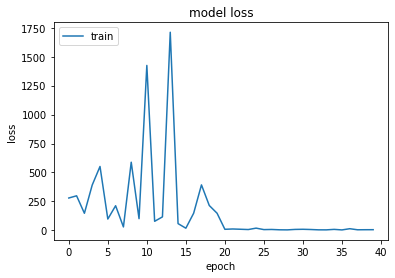

In [158]:
plt.plot(np.append(histories[0].history['training_loss'],histories[1].history['training_loss']))
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [159]:
def extract_layers(main_model, starting_layer_ix, ending_layer_ix):
    new_model = Sequential()
    for ix in range(starting_layer_ix, ending_layer_ix):
        curr_layer = main_model.get_layer(index=ix)
        print(curr_layer)
        new_model.add(curr_layer)
    return new_model

In [160]:
encoder = extract_layers(lstm_ae,1,14)

decoder = extract_layers(lstm_ae,14,26)

In [161]:
encoder.build((None,fixed_num_bins))
decoder.build((None,latent_dim))

In [162]:
encoder.summary()
decoder.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 1000)              0         
_________________________________________________________________
dense_40 (Dense)             (None, 256)               256256    
_________________________________________________________________
batch_normalization_32 (Batc (None, 256)               1024      
_________________________________________________________________
dense_41 (Dense)             (None, 128)               32896     
_________________________________________________________________
batch_normalization_33 (Batc (None, 128)               512       
_________________________________________________________________
leaky_re_lu_24 (LeakyReLU)   (None, 128)               0         
_________________________________________________________________
dense_42 (Dense)             (None, 64)               

In [163]:
encoded_valid = encoder.predict(valid_data)
encoded_train = encoder.predict(train_data)
encoded_test = encoder.predict(test_data)

In [164]:
decoded_valid = decoder.predict(encoded_valid)
decoded_train = decoder.predict(encoded_train)
decoded_test = decoder.predict(encoded_test)

In [165]:
path = os.path.join(root_models,'encoder_%s'%label_2)
encoder.save(path)
path = os.path.join(root_models,'decoder_%s'%label_2)
decoder.save(path)

INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/encoder_galaxies_quasars_bins1000_wl3388-8318_minz005_maxz036_minSN50_10_fully_connected/assets
INFO:tensorflow:Assets written to: /global/cscratch1/sd/vboehm/Models/SDSS_AE/decoder_galaxies_quasars_bins1000_wl3388-8318_minz005_maxz036_minSN50_10_fully_connected/assets


In [166]:
path = os.path.join(root_models,'encoder_%s'%label_2)
encoder = tf.keras.models.load_model(path)
path = os.path.join(root_models,'decoder_%s'%label_2)
decoder = tf.keras.models.load_model(path)

In [167]:
np.save(os.path.join(root_encoded,'encoded_%s.npy'%label_2),[encoded_train, encoded_valid, encoded_test])
encoded_train, encoded_valid, encoded_test = np.load(os.path.join(root_encoded,'encoded_%s.npy'%label_2), allow_pickle=True)

/global/homes/v/vboehm/.conda/envs/tf22/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


In [168]:
np.save(os.path.join(root_decoded,'decoded_%s.npy'%label_2),[decoded_train,decoded_valid, decoded_test])

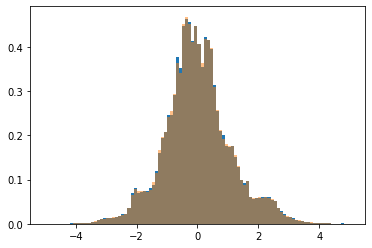

In [169]:
_=plt.hist(encoded_valid.flatten(),bins=100,density=True, range=(-5,5))
_=plt.hist(encoded_train.flatten(),bins=100,density=True, range=(-5,5), alpha=0.5)

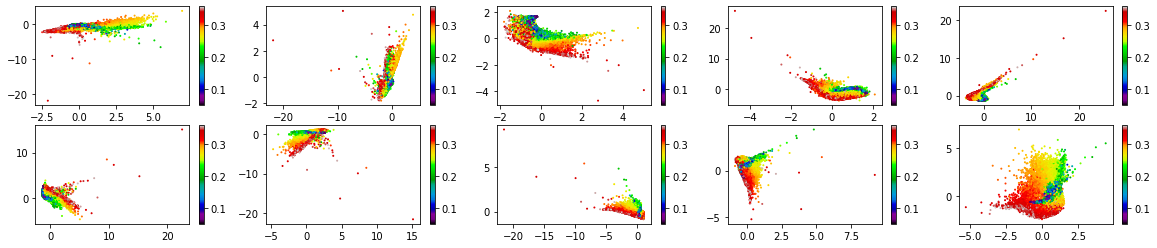

In [170]:
fig, ax = plt.subplots(2,5, figsize=(20,4))
ax=ax.flatten()
for ii in range(10):
    jj= (ii+1)%10
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=valid_params, cmap='nipy_spectral',s=1)
    plt.colorbar(im, ax=ax[ii])
plt.show()

In [171]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
le.fit(sublabel)
print(le.classes_, le.transform(le.classes_))

[b'' b'AGN' b'AGN BROADLINE' b'BROADLINE' b'STARBURST'
 b'STARBURST BROADLINE' b'STARFORMING' b'STARFORMING BROADLINE'] [0 1 2 3 4 5 6 7]


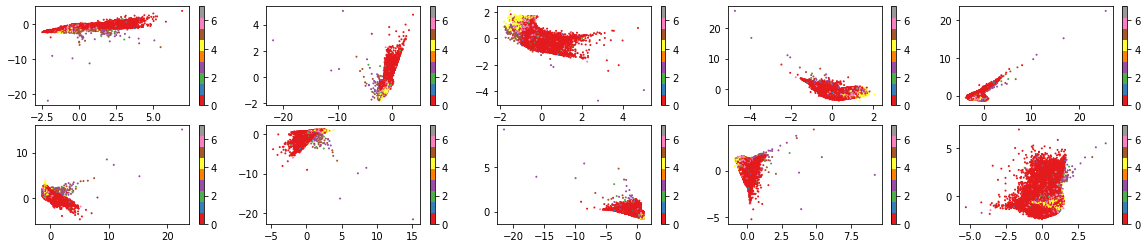

In [172]:
fig, ax = plt.subplots(2,5, figsize=(20,4))
ax=ax.flatten()
for ii in range(10):
    jj= (ii+1)%10
    im = ax[ii].scatter(encoded_valid[:,ii],encoded_valid[:,jj],c=le.transform(valid_labels), cmap='Set1', s=1)
    plt.colorbar(im, ax=ax[ii])
plt.show()

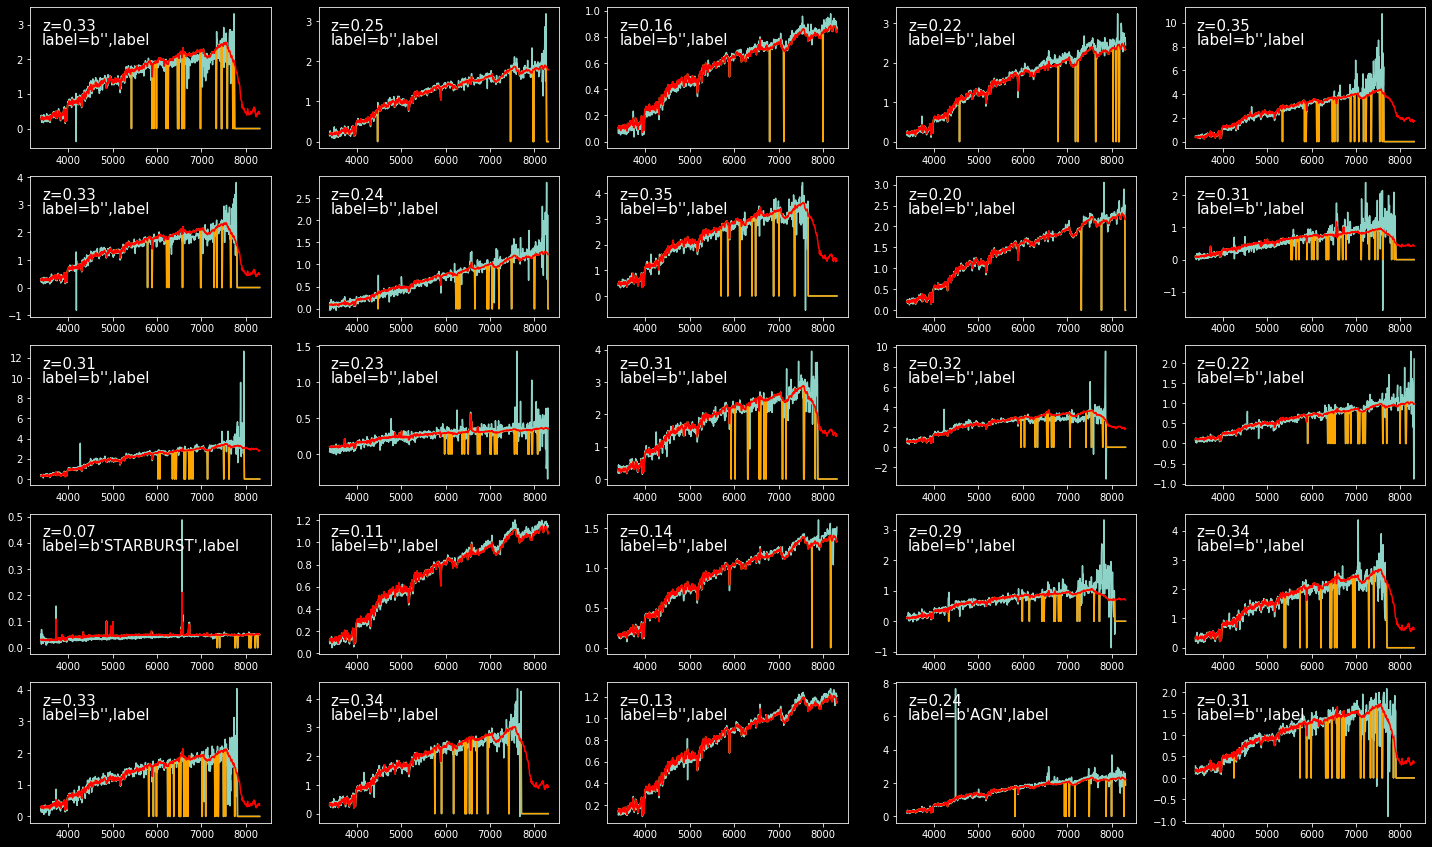

In [173]:
style_list=['dark_background']
# Plot a demonstration figure for every available style sheet.
for style_label in style_list:
    with plt.rc_context({"figure.max_open_warning": len(style_list)}):
        with plt.style.context(style_label):
            fig, ax = plt.subplots(5,5, figsize=(25,15))
            ax = ax.flatten()
            for nn, ii in enumerate(np.arange(25)):
                ax[nn].plot(new_wl[:-1], np.squeeze(valid_data)[ii]*np.squeeze(valid_mask)[ii], )
                ax[nn].plot(new_wl[:-1], np.squeeze(decoded_valid)[ii]*np.squeeze(valid_mask)[ii], color='orange')
                ax[nn].plot(new_wl[:-1], np.squeeze(decoded_valid)[ii], color='red')
                ax[nn].text(0.05, 0.92, r'z=%.2f'%valid_params[ii], fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
                ax[nn].text(0.05, 0.82, r'label=%s,%s'%(valid_labels[ii],valid_cat[ii]), fontsize=15, color='white',verticalalignment='top', horizontalalignment='left', transform=ax[nn].transAxes)
plt.show()